# Vector-Borne Disease Classifier — End-to-end notebook
**Filename:** `vector_borne_classifier_notebook.ipynb`  
**Author / Team:** Ayushmitra (Pushkar Kumar & team)  
**Purpose:** Train and evaluate models to classify vector-borne diseases (Malaria, Dengue, Yellow Fever, Typhoid, None) using the Burkina Faso tabular dataset (data.csv).  
This notebook covers: EDA → preprocessing → train/validation/test split → model training (Logistic Regression, Random Forest, Keras NN) → evaluation → save artifacts to Google Drive → prediction helper for chatbot integration → upload to Hugging Face.  

**Notes**
- Place `data.csv` (and optionally `description.xlsx`) inside:  
  `/content/drive/MyDrive/Ayushmitra_Models/vector_borne_classifier/`  
- All artifacts (models, scaler, feature list, metadata) will be saved to the same Drive folder.
- This notebook is written to be copy-paste friendly for Google Colab.


In [1]:
# Mount Google Drive (Colab)
from google.colab import drive
drive.mount('/content/drive')

# Set project folder path (modify if needed)
DRIVE_MODEL_DIR = "/content/drive/MyDrive/SIH_2025/Ayushmitra_Models/vector_borne_classifier"
print("Model / data folder:", DRIVE_MODEL_DIR)

# Ensure folder exists and list files
import os
if os.path.exists(DRIVE_MODEL_DIR):
    print("Files in folder (first 50):")
    print(os.listdir(DRIVE_MODEL_DIR)[:50])
else:
    raise FileNotFoundError(f"Folder not found: {DRIVE_MODEL_DIR}. Create it and upload data.csv & description.xlsx there.")


Mounted at /content/drive
Model / data folder: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/vector_borne_classifier
Files in folder (first 50):
['data.csv', 'desciption.xlsx', 'Tabular dataset for AI-based vector-borne disease prediction.zip', 'vector_borne_classifier_notebook.ipynb']


## Install & Imports
We will import necessary libraries. Uncomment the pip installs if running in a fresh Colab environment.
- `tensorflow` for Keras neural network
- `scikit-learn` for classical ML and metrics
- `joblib` for saving scalers/encoders
- `huggingface_hub` for optional upload


In [2]:
# (Uncomment to install in a fresh runtime)
# !pip install -q tensorflow scikit-learn joblib seaborn matplotlib huggingface_hub openpyxl

import pandas as pd
import numpy as np
import os, json, joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

sns.set(style="whitegrid")
print("Libraries imported.")


Libraries imported.


## Load dataset
Load `data.csv` (and optionally `description.xlsx`) from the Drive folder. We'll inspect the first rows and basic shape.


In [4]:
DATA_CSV = os.path.join(DRIVE_MODEL_DIR, "data.csv")
DESC_XLSX = os.path.join(DRIVE_MODEL_DIR, "description.xlsx")  # optional

if not os.path.exists(DATA_CSV):
    raise FileNotFoundError(f"Dataset not found: {DATA_CSV}. Upload data.csv to this folder.")

try:
    # Try different delimiters if the default comma fails
    df = pd.read_csv(DATA_CSV, delimiter=';') # Assuming semicolon is a possible delimiter
except Exception as e:
    print(f"Could not read CSV with semicolon delimiter: {e}")
    try:
        df = pd.read_csv(DATA_CSV, delimiter='\t') # Try tab delimiter
    except Exception as e:
        print(f"Could not read CSV with tab delimiter: {e}")
        # If other delimiters fail, try reading with no delimiter and a single column
        try:
            df = pd.read_csv(DATA_CSV, header=None)
            print("Read as single column, potentially requires further parsing.")
        except Exception as e:
            raise Exception(f"Failed to read CSV with multiple delimiters. Error: {e}")


print("Dataset shape:", df.shape)
display(df.head())

if os.path.exists(DESC_XLSX):
    try:
        desc = pd.read_excel(DESC_XLSX)
        print("Description file loaded. Columns in description:", desc.columns.tolist())
    except Exception as e:
        print("Couldn't read description.xlsx:", e)

Dataset shape: (300, 109)


,Centre de santé,Genre (Gender),Âge (Age),Poids (Weight),Circonference du bras (Mua circumference),"Haute température.(temperature, Hyperpyrexia)",Fièvre depuis 48 heures(Fever 48 hrs),Fièvre au cours des 7 derniers jours (Fever in the last 7 days),Type de fièvre (Type of Fever),Perte de poids (Loss of Weight),...,Maladies diagnostiquées/Paludisme (Malaria),Maladies diagnostiquées/Dengue,Maladies diagnostiquées/Chikunguya,Maladies diagnostiquées/Fièvre jaune (yellow fever),Maladies diagnostiquées/Fièvre Typhoïde (Thyphoid fever),Maladies diagnostiquées/Zika,Maladies diagnostiquées/Autres maladies diagnostiqué (Others diseases),Maladies diagnostiquées/Option 8,Autres maladies présentées par le patient,_uuid
0,CMA de DO,Femme,18,55.0,NaN,OUI,OUI,OUI,Récurrente,NON,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,df22d899-23a3-4c49-8059-6208c130f57d
1,CMA de DO,Homme,26,120.0,NaN,OUI,OUI,OUI,Récurrente,NON,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4a7ef2f3-4ff0-4215-8cb5-20ba8c8d4355
2,CMA de DO,Homme,25,63.0,NaN,OUI,OUI,OUI,Récurrente,NON,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,104f6bc8-f39a-482b-b680-7ac1f8cccc86
3,CMA de DO,Homme,3,12.0,"13,5",OUI,OUI,NON,Récurrente,NON,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,26d7d04a-1a1c-4d4b-b64a-606f968e6d9c
4,CMA de DO,Homme,8,24.0,NaN,OUI,OUI,NON,Récurrente,NON,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,eb694f52-51ff-488d-9beb-2923a572a4cf


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Poids (Weight)'].plot(kind='hist', bins=20, title='Poids (Weight)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Genre (Gender)').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('Âge (Age)').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Circonference du bras (Mua circumference)').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('Fièvre au cours des 7 derniers jours (Fever in the last 7 days)').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='index', y='Poids (Weight)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Poids (Weight)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Genre (Gender)')):
  _plot_series(series, series_name, i)
  fig.legend(title='Genre (Gender)', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Poids (Weight)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Poids (Weight)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Âge (Age)')):
  _plot_series(series, series_name, i)
  fig.legend(title='Âge (Age)', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Poids (Weight)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Poids (Weight)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Circonference du bras (Mua circumference)')):
  _plot_series(series, series_name, i)
  fig.legend(title='Circonference du bras (Mua circumference)', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Poids (Weight)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Poids (Weight)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Fièvre au cours des 7 derniers jours (Fever in the last 7 days)')):
  _plot_series(series, series_name, i)
  fig.legend(title='Fièvre au cours des 7 derniers jours (Fever in the last 7 days)', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Poids (Weight)')

from matplotlib import pyplot as plt
_df_11['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['Poids (Weight)'].plot(kind='line', figsize=(8, 4), title='Poids (Weight)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Âge (Age)'].value_counts()
    for x_label, grp in _df_13.groupby('Genre (Gender)')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Genre (Gender)')
_ = plt.ylabel('Âge (Age)')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Circonference du bras (Mua circumference)'].value_counts()
    for x_label, grp in _df_14.groupby('Âge (Age)')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Âge (Age)')
_ = plt.ylabel('Circonference du bras (Mua circumference)')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Fièvre au cours des 7 derniers jours (Fever in the last 7 days)'].value_counts()
    for x_label, grp in _df_15.groupby('Circonference du bras (Mua circumference)')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Circonference du bras (Mua circumference)')
_ = plt.ylabel('Fièvre au cours des 7 derniers jours (Fever in the last 7 days)')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Nausée (Nausea)'].value_counts()
    for x_label, grp in _df_16.groupby('Fièvre au cours des 7 derniers jours (Fever in the last 7 days)')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Fièvre au cours des 7 derniers jours (Fever in the last 7 days)')
_ = plt.ylabel('Nausée (Nausea)')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['Genre (Gender)'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='index', y='Genre (Gender)', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['Âge (Age)'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='index', y='Âge (Age)', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Circonference du bras (Mua circumference)'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='index', y='Circonference du bras (Mua circumference)', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Fièvre au cours des 7 derniers jours (Fever in the last 7 days)'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='index', y='Fièvre au cours des 7 derniers jours (Fever in the last 7 days)', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## Quick EDA (Exploratory Data Analysis)
We will:
- Inspect columns & datatypes
- Check missing values
- Check class distribution
- Show basic statistics and histograms for numeric columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Columns: 109 entries, Centre de santé to _uuid
dtypes: float64(12), object(97)
memory usage: 255.6+ KB


None


Missing values per column:
Centre de santé                                                             0
Genre (Gender)                                                              2
Âge (Age)                                                                   0
Poids (Weight)                                                            104
Circonference du bras (Mua circumference)                                 275
                                                                         ... 
Maladies diagnostiquées/Zika                                                1
Maladies diagnostiquées/Autres maladies diagnostiqué (Others diseases)      1
Maladies diagnostiquées/Option 8                                            1
Autres maladies présentées par le patient                                 206
_uuid                                                                       0
Length: 109, dtype: int64

Columns: ['Centre de santé', 'Genre (Gender)', 'Âge (Age)', 'Poids (Weight)', 'Circonfe

,Poids (Weight),Fréquence respiratoire (médiane IQR) / Respiratory rate (median breaths/min IQR),Temps de remplissage capillaire (médiane secs IQR). / Capillary refill time (median secs IQR),Créatinine élevée / Elevated Creatinine,Maladies diagnostiquées/Paludisme (Malaria),Maladies diagnostiquées/Dengue,Maladies diagnostiquées/Chikunguya,Maladies diagnostiquées/Fièvre jaune (yellow fever),Maladies diagnostiquées/Fièvre Typhoïde (Thyphoid fever),Maladies diagnostiquées/Zika,Maladies diagnostiquées/Autres maladies diagnostiqué (Others diseases),Maladies diagnostiquées/Option 8
count,196.000000,212.000000,91.000000,218.000000,299.00000,299.000000,299.0,299.000000,299.00000,299.0,299.000000,299.0
mean,32.571429,33.757075,6.516484,432.088073,0.90301,0.187291,0.0,0.040134,0.09699,0.0,0.331104,0.0
std,27.370207,9.989905,40.216459,4802.634365,0.29644,0.390799,0.0,0.196602,0.29644,0.0,0.471399,0.0
min,2.000000,6.000000,2.000000,4.000000,0.00000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0
25%,11.000000,28.000000,2.000000,64.500000,1.00000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0
50%,18.000000,32.000000,2.000000,90.000000,1.00000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0
75%,54.250000,38.000000,2.000000,106.000000,1.00000,0.000000,0.0,0.000000,0.00000,0.0,1.000000,0.0
max,131.000000,66.000000,385.000000,71000.000000,1.00000,1.000000,0.0,1.000000,1.00000,0.0,1.000000,0.0


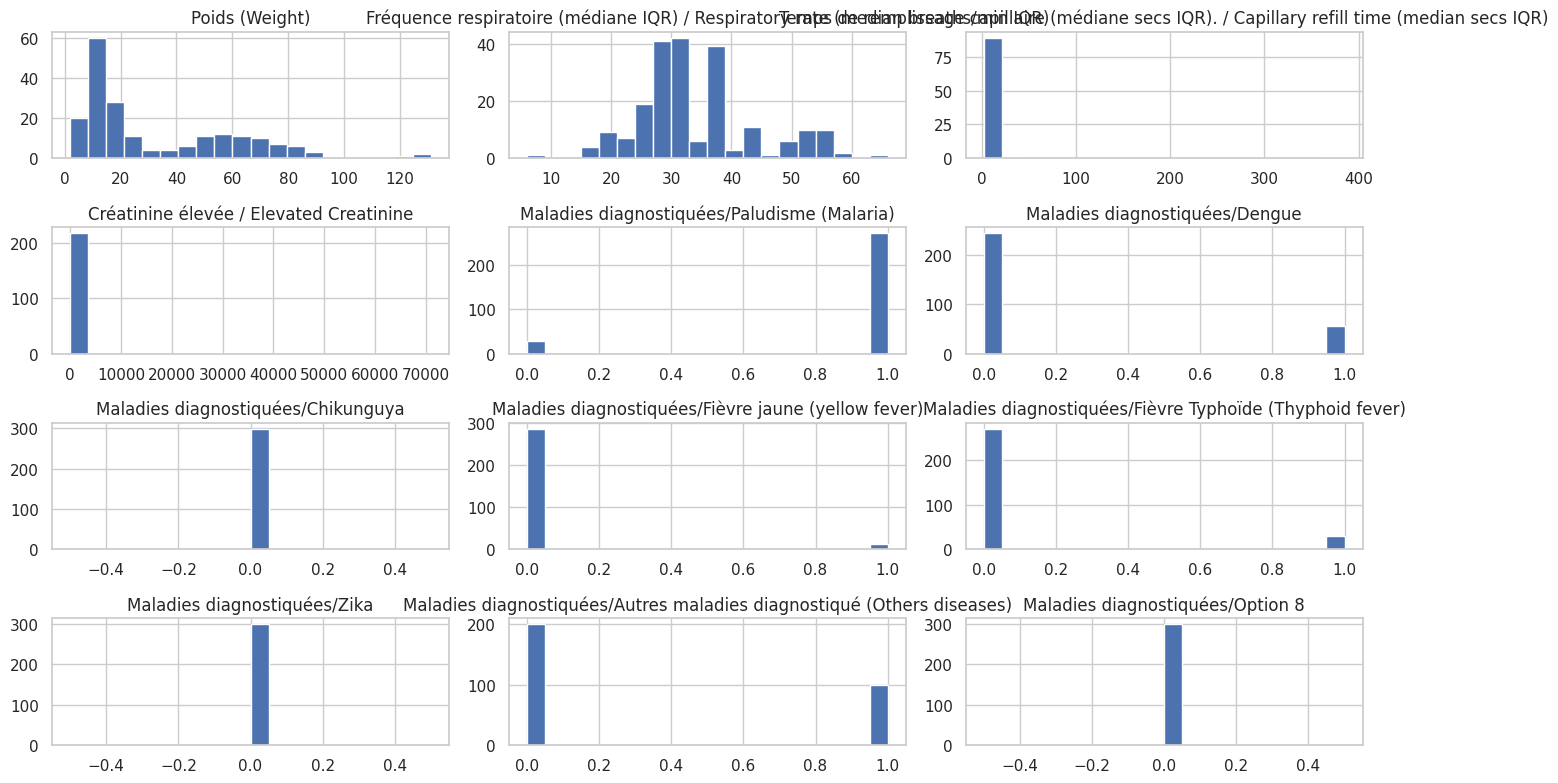

In [5]:
# Normalize column names (strip spaces)
df.columns = [c.strip() for c in df.columns]

# Info & missing values
display(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())

# Show column list
print("\nColumns:", df.columns.tolist())

# Detect likely target column (try common names)
target_candidates = ['disease','Disease','DiseaseLabel','disease_label','target','Target','label','Label']
target_col = None
for c in target_candidates:
    if c in df.columns:
        target_col = c
        break
if target_col is None:
    # fallback: if there's a column with few unique strings look for it
    for c in df.columns:
        if df[c].dtype == object and df[c].nunique() <= 10:
            target_col = c
            break

if target_col is None:
    raise KeyError("Target column not found. Expected a column like 'disease' or similar. Columns: " + ", ".join(df.columns[:50]))

print(f"\nDetected target column: {target_col}")
print(df[target_col].value_counts(dropna=False))

# Numeric summary
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns:", numeric_cols)
display(df[numeric_cols].describe())

# Histograms for numeric features (if any)
if numeric_cols:
    df[numeric_cols].hist(bins=20, figsize=(14,8))
    plt.tight_layout()


In [6]:
# Create a dictionary to map French column names to English
# This is a partial mapping based on the observed columns. You might need to add more.
column_translation = {
    'Centre de santé': 'Health Center',
    'Genre (Gender)': 'Gender',
    'Âge (Age)': 'Age',
    'Poids (Weight)': 'Weight',
    'Circonference du bras (Mua circumference)': 'Arm Circumference',
    'Haute température.(temperature, Hyperpyrexia)': 'High Temperature (Hyperpyrexia)',
    'Fièvre depuis 48 heures(Fever 48 hrs)': 'Fever since 48 hrs',
    'Fièvre au cours des 7 derniers jours (Fever in the last 7 days)': 'Fever in the last 7 days',
    'Type de fièvre (Type of Fever)': 'Type of Fever',
    'Perte de poids (Loss of Weight)': 'Loss of Weight',
    'Maux de tête (headache)': 'Headache',
    'Nausée (Nausea)': 'Nausea',
    'Vomissement (Vomiting)': 'Vomiting',
    'Douleur articulaire (Joint pain)': 'Joint Pain',
    'Gonflement des articulations (Joint Swelling)': 'Joint Swelling',
    'Douleur musculaire ( Muscle pain)': 'Muscle Pain',
    'Douleur Thoracique (Chaist pain)': 'Chest Pain',
    'Mal de dos / Douleur rachidienne ( Back pain / Rachiodynia)': 'Back Pain / Rachiodynia',
    'Troubles de la conscience (Consciousness trouble)': 'Consciousness Trouble',
    "Perte d'appétit ou Anorexie (Loss of appetite or Anorexia)": "Loss of Appetite or Anorexia",
    'Éruptions cutanées ou Exanthème (Skin rash or Exanthema)': 'Skin Rash or Exanthema',
    'Éruption morbilliforme (Morbilliform rash)': 'Morbilliform Rash',
    'Saignement/ Manifestations hémorragiques (Bleeding)': 'Bleeding / Hemorrhagic Manifestations',
    'Rhinorrhée (Rhinorrhea)': 'Rhinorrhea',
    'Somnolence ou léthargie  (Drowsiness or lethargy)': 'Drowsiness or Lethargy',
    'Vertige (Dizzy)': 'Dizzy',
    'Inflammation de conjonctivite': 'Conjunctivitis Inflammation',
    'Douleur abdominale (stomac pain)': 'Abdominal Pain (Stomach Pain)',
    'Distension abdominale (Ventre gonflé) (Abdominal Distension (Swelling Stomach)/ Ascites)': 'Abdominal Distension (Swelling Stomach) / Ascites',
    'Mal de gorge (throat pain)': 'Throat Pain',
    'Toux (Cough)': 'Cough',
    'Diarrhée  (Diarrhea)': 'Diarrhea',
    'Douleur rétro-orbitrale (Retro-orbital pain)': 'Retro-orbital Pain',
    'Céphalée (Headache)': 'Headache',
    'Sensation de frissons ou de froid (Shiver or cold sensation)': 'Shiver or Cold Sensation',
    'Mictions fréquentes.(Frequent Urination)': 'Frequent Urination',
    'Constipation': 'Constipation',
    'Oligurie (Oliguria)': 'Oliguria',
    'Prostration': 'Prostration',
    'Ictère (Icterus)': 'Icterus',
    'Epistaxis ((Bleeding nose)': 'Epistaxis (Bleeding Nose)',
    'Convulsions généralisées ou focales (Generalised or focal convulsion)': 'Generalised or Focal Convulsion',
    'Convulsions multiples (Multiple convulsions)': 'Multiple Convulsions',
    'Délire': 'Delirium',
    'Confusion/ niveau de conscience altéré (impaired level of consciousness)': 'Confusion / Impaired Level of Consciousness',
    'Rougeur faciale (Facial flushing)': 'Facial Flushing',
    'Gonflement du visage (Facial Swelling)': 'Facial Swelling',
    'Sudation excessive (Profuse sweating)': 'Profuse Sweating',
    'Délire /Discours irrationnel (Delirium/ Irrational Talking)': 'Delirium / Irrational Talking',
    'Hémoglobinurie (Hemoglobinuria)': 'Hemoglobinuria',
    'Goût amer dans la gorge (Bitter taste in your Throat)': 'Bitter Taste in your Throat',
    'Test de garrot positif (Positive tourniquet test)': 'Positive Tourniquet Test',
    'Raideur (Stiffness)': 'Stiffness',
    'Détresse respiratoire (Respiratory distress)': 'Respiratory Distress',
    'Choc septique (Shock)': 'Shock',
    'Hépatomégalie (Hepatomegaly)': 'Hepatomegaly',
    'Insuffisance cardiaque  ou Myocardite(Heart failure or Myocarditis)': 'Heart Failure or Myocarditis',
    'Accumulation de liquide et détresse respiratoire (Accumulation of fluid and respiratory distress)': 'Accumulation of Fluid and Respiratory Distress',
    'Splénomégalie modérée': 'Moderate Splenomegaly',
    'Choc septique (Septicemia)': 'Septicemia Shock',
    "Syndrome d'icterus subaigu (Sub-icterus)": 'Sub-icterus Syndrome',
    'Lymphadénopathie / Lymphadenopa thy': 'Lymphadenopathy',
    'Température axillaire (médiane IQR) (°C) /Axillary temperature (median IQR) (°C)': 'Axillary Temperature (median IQR) (°C)',
    'Fréquence respiratoire (médiane IQR) / Respiratory rate (median breaths/min IQR)': 'Respiratory Rate (median breaths/min IQR)',
    'Fréquence du pouls (battements/m in ± SD)./ Pulse rate (mean beats/min ± SD) - Shock ou Myocarditis': 'Pulse Rate (mean beats/min ± SD) - Shock or Myocarditis',
    'Pression artérielle (moyenne mmHg ± SD). / Arterial blood pressure (mean mmHg ± SD)': 'Arterial Blood Pressure (mean mmHg ± SD)',
    'Temps de remplissage capillaire (médiane secs IQR). / Capillary refill time (median secs IQR)': 'Capillary Refill Time (median secs IQR)',
    'Test TDR': 'RDT Test',
    'Goutte épaisse': 'Thick Smear',
    'Hémoconcentration': 'Hemoconcentration',
    'Pâleur cutanéo muqueuse ou Anémie (Mucosal skin pallor or Anemia)': 'Mucosal Skin Pallor or Anemia',
    'Hypoglycémie (Hypoglycemia)': 'Hypoglycemia',
    'Hematocrite (Hematrocrit)': 'Hematocrit',
    'Transaminases (Transaminases)': 'Transaminases',
    'Thrombocytopénie(Thrombocytopenia)': 'Thrombocytopenia',
    'Lymphocytopénie (Lymphocytopenia)': 'Lymphocytopenia',
    'Lymphocytes': 'Lymphocytes',
    'Neutropénie (Neutropenia)': 'Neutropenia',
    'Nombre de globules blancs (cellules/ML) / White blood cell count / WBC count (cells/ML)': 'White Blood Cell Count / WBC Count (cells/ML)',
    'Numération plaquettaire Platelet count': 'Platelet Count',
    'Neutrophiles / Neutrophils': 'Neutrophils',
    'CRP>50 /CRP 10-50': 'CRP > 50 / CRP 10-50',
    'Créatinine élevée / Elevated Creatinine': 'Elevated Creatinine',
    'ALAT / ASAT élevés. / Elevated ALAT / Elevated ASAT': 'Elevated ALAT / Elevated ASAT',
    'Diabète': 'Diabetes',
    'Hypertension artérielle': 'Hypertension',
    'Drépanocytose': 'Sickle Cell Disease',
    'Maladie rhumatismale': 'Rheumatic Disease',
    'Maladie auto immune': 'Autoimmune Disease',
    'Arthrose': 'Osteoarthritis',
    'Allergies': 'Allergies',
    'Cancer': 'Cancer',
    'Asthme (Astma)': 'Asthma',
    'Carences en leucocytes (Leucopenia)': 'Leukopenia',
    'Pneumonie (Pneumonia)': 'Pneumonia',
    'Dengue dans le menage (Household Dengue)': 'Household Dengue',
    'Dengue (Dengua)': 'Dengue',
    'Maladies diagnostiquées': 'Diagnosed Diseases',
    'Maladies diagnostiquées/Paludisme (Malaria)': 'Diagnosed Diseases/Malaria',
    'Maladies diagnostiquées/Dengue': 'Diagnosed Diseases/Dengue',
    'Maladies diagnostiquées/Chikunguya': 'Diagnosed Diseases/Chikungunya',
    'Maladies diagnostiquées/Fièvre jaune (yellow fever)': 'Diagnosed Diseases/Yellow Fever',
    'Maladies diagnostiquées/Fièvre Typhoïde (Thyphoid fever)': 'Diagnosed Diseases/Typhoid Fever',
    'Maladies diagnostiquées/Zika': 'Diagnosed Diseases/Zika',
    'Maladies diagnostiquées/Autres maladies diagnostiqué (Others diseases)': 'Diagnosed Diseases/Other Diseases',
    'Maladies diagnostiquées/Option 8': 'Diagnosed Diseases/Option 8',
    'Autres maladies présentées par le patient': 'Other Diseases Presented by Patient',
    '_uuid': '_uuid' # Keeping uuid as is
}

# Rename the columns
df.rename(columns=column_translation, inplace=True)

# Display the first few rows with translated columns
display(df.head())

,Health Center,Gender,Age,Weight,Arm Circumference,High Temperature (Hyperpyrexia),Fever since 48 hrs,Fever in the last 7 days,Type of Fever,Loss of Weight,...,Diagnosed Diseases/Malaria,Diagnosed Diseases/Dengue,Diagnosed Diseases/Chikungunya,Diagnosed Diseases/Yellow Fever,Diagnosed Diseases/Typhoid Fever,Diagnosed Diseases/Zika,Diagnosed Diseases/Other Diseases,Diagnosed Diseases/Option 8,Other Diseases Presented by Patient,_uuid
0,CMA de DO,Femme,18,55.0,NaN,OUI,OUI,OUI,Récurrente,NON,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,df22d899-23a3-4c49-8059-6208c130f57d
1,CMA de DO,Homme,26,120.0,NaN,OUI,OUI,OUI,Récurrente,NON,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4a7ef2f3-4ff0-4215-8cb5-20ba8c8d4355
2,CMA de DO,Homme,25,63.0,NaN,OUI,OUI,OUI,Récurrente,NON,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,104f6bc8-f39a-482b-b680-7ac1f8cccc86
3,CMA de DO,Homme,3,12.0,"13,5",OUI,OUI,NON,Récurrente,NON,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,26d7d04a-1a1c-4d4b-b64a-606f968e6d9c
4,CMA de DO,Homme,8,24.0,NaN,OUI,OUI,NON,Récurrente,NON,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,eb694f52-51ff-488d-9beb-2923a572a4cf


# Task
Translate the remaining non-numeric, non-English string data in the dataframe to English.

## Identify columns with non-numeric, non-translated string data

### Subtask:
Determine which columns still contain string values that need translation, excluding columns that were already addressed by column name translation or are purely numerical or contain NaN values.


**Reasoning**:
Identify columns with object dtype that were not previously translated and appear to contain non-numeric string data by inspecting unique values.



In [7]:
untranslated_string_columns = []
translated_column_names = list(column_translation.values())

for column in df.columns:
    # Check if the column was already translated based on name
    if column in translated_column_names:
        continue

    # Check if the column has object dtype
    if df[column].dtype == 'object':
        unique_values = df[column].unique()

        # Check if the unique values are not just NaN
        if not pd.isna(unique_values).all():
            # Check if the unique values appear to be non-numeric strings
            is_numeric_like = True
            for value in unique_values:
                if pd.notna(value):
                    try:
                        # Try converting to float to see if it's numeric-like
                        float(str(value).replace(',', '.')) # Handle potential comma decimals
                    except ValueError:
                        is_numeric_like = False
                        break

            if not is_numeric_like:
                untranslated_string_columns.append(column)

print("Columns with potentially untranslated string data:")
print(untranslated_string_columns)


Columns with potentially untranslated string data:
['Mictions fréquentes. (Frequent Urination)']


## Inspect unique values in identified columns

### Subtask:
Examine the unique values within these columns to understand the scope and nature of the data to be translated.


**Reasoning**:
Iterate through the identified columns and print their unique values to understand the data that needs translation.



In [8]:
for column in untranslated_string_columns:
    print(f"\nUnique values for column: {column}")
    print(df[column].unique())


Unique values for column: Mictions fréquentes. (Frequent Urination)
['NON' 'OUI' nan]


## Translate unique values

### Subtask:
Create a mapping (dictionary) for the unique values that need translation. This step may require external resources or user input for accurate translations.


**Reasoning**:
Based on the previous step, the column 'Mictions fréquentes. (Frequent Urination)' contains unique values 'NON', 'OUI', and NaN. I will create a dictionary to map 'NON' to 'No', 'OUI' to 'Yes', and NaN to NaN.



In [9]:
translation_map = {
    'NON': 'No',
    'OUI': 'Yes',
    np.nan: np.nan
}

print("Translation map created:")
print(translation_map)

Translation map created:
{'NON': 'No', 'OUI': 'Yes', nan: nan}


## Apply translation to the dataframe

### Subtask:
Use the created translation map to translate the values in the identified columns of the dataframe.

**Reasoning**:
Apply the `translation_map` to the 'Mictions fréquentes. (Frequent Urination)' column using the `.map()` function to replace the French values with their English counterparts.

In [10]:
for column in untranslated_string_columns:
    df[column] = df[column].map(translation_map)

print("Translation applied to the identified columns.")

Translation applied to the identified columns.


## Verify translation

### Subtask:
Check a sample of the translated data to ensure accuracy and completeness.

**Reasoning**:
Display the unique values and their counts for the columns that were translated to confirm the translation was applied correctly.

In [11]:
for column in untranslated_string_columns:
    print(f"\nUnique values after translation for column: {column}")
    display(df[column].value_counts(dropna=False))


Unique values after translation for column: Mictions fréquentes. (Frequent Urination)


,count
Mictions fréquentes. (Frequent Urination),
No,295
Yes,3
NaN,2


## Inspect the 'Other Diseases Presented by Patient' column

### Subtask:
Examine the unique values in the 'Other Diseases Presented by Patient' column to identify foreign language entries.

**Reasoning**:
Display the unique values in the 'Other Diseases Presented by Patient' column to understand the variety of entries and identify those in a foreign language.

In [12]:
print("Unique values in 'Other Diseases Presented by Patient' column:")
display(df['Other Diseases Presented by Patient'].unique())

Unique values in 'Other Diseases Presented by Patient' column:


array([nan, 'Bronchite Aigue', 'Gastro Entente Aigue Febrile', 'sepsio',
       'Pneumonie', 'Épilepsie', 'Cardiopathie', 'Drépanocytose (ss)',
       'Syndromes Infectieux', 'Diabete + HTA', 'BPP', 'Pneumonie, UGD',
       'Bronchopneumopathie (BPP)', 'UGD',
       'Ulcere Gastro Duostanole (UGD)', 'Pneumonie Sévère', 'pneumonie',
       'sepsis', 'HTA', 'Sepsis', 'Pneumonie  Sévère', 'Angine de gorge',
       'Drepanocytaire', 'GEA', 'Cardiopathie décompensée',
       'BPP a  BK  Tuberculose puitomiale', 'Pneumopathie',
       'Sepsis, Meningo  -  encephalité', 'Infection  bacterienne', 'MCS',
       'Syndrome   Néphrotique', 'Sepsis,  Anémie', 'R',
       'Laryngite  aigue', 'MCS, Pneumonie', 'MAS,  GEAF',
       'Broncho pneumopathie  A', 'Anemie', 'Insuffisance Rénale',
       'Rougeole,  Varicelle,  GEAF', 'MAS(Déshydratation)', 'Bronchite',
       'Meningite', 'BroncoPneumopathie (BPP)',
       'Gastro enterite  Aigue  Febril', 'Infection du tracus urinaire',
       "Crise  Hémo

## Translate 'Other Diseases Presented by Patient' column

### Subtask:
Create a translation mapping for common terms in the 'Other Diseases Presented by Patient' column and apply it to the dataframe.

**Reasoning**:
Create a dictionary to map the observed French unique values in the 'Other Diseases Presented by Patient' column to their English counterparts and apply the mapping to the column.

In [13]:
# Create a translation map for the observed unique values in 'Other Diseases Presented by Patient'
other_diseases_translation_map = {
    'Bronchite Aigue': 'Acute Bronchitis',
    'Gastro Entente Aigue Febrile': 'Acute Febrile Gastroenteritis',
    'sepsio': 'sepsis',
    'Pneumonie': 'Pneumonia',
    'Épilepsie': 'Epilepsy',
    'Cardiopathie': 'Cardiopathy',
    'Drépanocytose (ss)': 'Sickle Cell Disease (ss)',
    'Syndromes Infectieux': 'Infectious Syndromes',
    'Diabete + HTA': 'Diabetes + Hypertension',
    'BPP': 'Bronchopneumopathy', # Assuming BPP stands for Bronchopneumopathie
    'Pneumonie, UGD': 'Pneumonia, UGD', # UGD likely an abbreviation
    'Bronchopneumopathie (BPP)': 'Bronchopneumopathy (BPP)',
    'UGD': 'UGD', # Keeping UGD as is for now
    'Ulcere Gastro Duostanole (UGD)': 'Gastroduodenal Ulcer (UGD)',
    'Pneumonie Sévère': 'Severe Pneumonia',
    'pneumonie': 'pneumonia',
    'sepsis': 'sepsis',
    'HTA': 'Hypertension',
    'Sepsis': 'Sepsis',
    'Pneumonie  Sévère': 'Severe Pneumonia',
    'Angine de gorge': 'Sore Throat (Angina)',
    'Drepanocytaire': 'Sickle Cell', # Referring to Sickle Cell related issue
    'GEA': 'Acute Gastroenteritis', # Assuming GEA stands for Gastro Entérite Aigue
    'Cardiopathie décompensée': 'Decompensated Cardiopathy',
    'BPP a  BK  Tuberculose puitomiale': 'Bronchopneumopathy with BK Pulmonary Tuberculosis', # BK likely refers to Koch's bacillus
    'Pneumopathie': 'Pneumopathy',
    'Sepsis, Meningo  -  encephalité': 'Sepsis, Meningoencephalitis',
    'Infection  bacterienne': 'Bacterial Infection',
    'MCS': 'MCS', # Keeping MCS as is, likely an abbreviation
    'Syndrome   Néphrotique': 'Nephrotic Syndrome',
    'Sepsis,  Anémie': 'Sepsis, Anemia',
    'R': 'R', # Keeping R as is, unclear abbreviation
    'Laryngite  aigue': 'Acute Laryngitis',
    'MCS, Pneumonie': 'MCS, Pneumonia',
    'MAS,  GEAF': 'SAM, Acute Febrile Gastroenteritis', # MAS likely stands for Malnutrition Aigue Sévère (Severe Acute Malnutrition), GEAF is Acute Febrile Gastroenteritis
    'Broncho pneumopathie  A': 'Bronchopneumopathy A', # A likely type or grade
    'Anemie': 'Anemia',
    'Insuffisance Rénale': 'Renal Failure',
    'Rougeole,  Varicelle,  GEAF': 'Measles, Chickenpox, Acute Febrile Gastroenteritis',
    'MAS(Déshydratation)': 'SAM (Dehydration)',
    'Bronchite': 'Bronchitis',
    'Meningite': 'Meningitis',
    'BroncoPneumopathie (BPP)': 'Bronchopneumopathy (BPP)', # Correcting typo in original
    'Gastro enterite  Aigue  Febril': 'Acute Febrile Gastroenteritis', # Correcting typo in original
    'Infection du tracus urinaire': 'Urinary Tract Infection', # Correcting typo in original
    "Crise  Hémorroïdaire  Compliqué d'une anémie": "Hemorrhoidal Crisis Complicated by Anemia",
    'MCS,  PFA': 'MCS, PFA', # PFA likely an abbreviation
    'Gastro-Enteri Aigue Febrile': 'Acute Febrile Gastroenteritis', # Correcting typo in original
    'Hepato-pathie + Infection Respiration Aigue Febul (IRAF)': 'Hepatopathy + Acute Febrile Respiratory Infection (AFRI)', # IRAF likely stands for Infection Respiratoire Aigue Febrile
    'Salmonellose  digestive': 'Digestive Salmonellosis',
    'LOMBARTHROSE': 'Lumbar Osteoarthritis',
    "Pleuro pneumopathie Aigue sur sequelle d'AVC": 'Acute Pleuropneumonia on Stroke Sequelae',
    'Lombarthrose compliqué de déshydratation modérée  + IRA': 'Lumbar Osteoarthritis Complicated by Moderate Dehydration + ARF', # IRA likely stands for Insuffisance Rénale Aigue (Acute Renal Failure)
    'Ictère  Hepatite Toxique': 'Icterus Toxic Hepatitis',
    'BPP sur Cirrhose hepatique virale B': 'Bronchopneumopathy on Viral Hepatitis B Cirrhosis',
    'Sepsis a point de depart, Infection  oppotuniste': 'Sepsis with Point of Origin, Opportunistic Infection', # Correcting typo in original
    'Sepsis, HTA + Diabète': 'Sepsis, Hypertension + Diabetes',
    'Broncho  Pneumopathie Bilatérale': 'Bilateral Bronchopneumopathy',
    'Salmonelloge  Digestive': 'Digestive Salmonellosis', # Correcting typo in original
    'Epilepsie': 'Epilepsy',
    'Gastro Enterite  Fébrile': 'Febrile Gastroenteritis',
    'Gastro  Enterite Non Febrile': 'Non-Febrile Gastroenteritis',
    'GEAF': 'Acute Febrile Gastroenteritis', # Assuming GEAF stands for Gastro Entérite Aigue Fébrile
    'Bronchiolite,   Pneumonie': 'Bronchiolitis, Pneumonia',
    'GEAF, Pneumonie': 'Acute Febrile Gastroenteritis, Pneumonia',
    'AVC I / AVC H + IRA': 'Ischemic Stroke / Hemorrhagic Stroke + ARF', # AVC I/H likely refer to types of stroke
    'Lombarthrose': 'Lumbar Osteoarthritis',
    'AVC I + IRA': 'Ischemic Stroke + ARF',
    'IRA + Pyclonéphrite sur probable cardiopathie': 'ARF + Pyelonephritis on Probable Cardiopathy',
    'IRA + Diabete': 'ARF + Diabetes',
    'SALMONELOSE': 'Salmonellosis',
    'IRA': 'ARF', # Assuming IRA stands for Insuffisance Rénale Aigue (Acute Renal Failure)
    'Dengue B': 'Dengue B', # Keeping Dengue B as is
    'Intoxication au gaz': 'Gas Poisoning',
    'HTA + UGD': 'Hypertension + UGD',
    'Hepatite B positif': 'Hepatitis B Positive',
    'Hepatite  aigue virale + Cholecystite aigue': 'Acute Viral Hepatitis + Acute Cholecystitis',
    'HEMOPATHIE MALIGNE': 'Malignant Hematopathy',
    'Souffrance  rénale aigue bilatérale': 'Bilateral Acute Renal Distress',
    'Traumatisme fermé de la hanche': 'Closed Hip Trauma',
    'Drépanocytose +  Dengue B': 'Sickle Cell Disease + Dengue B',
    np.nan: np.nan # Keep NaN as is
}

# Apply the translation map
df['Other Diseases Presented by Patient'] = df['Other Diseases Presented by Patient'].map(other_diseases_translation_map)

print("Translation applied to 'Other Diseases Presented by Patient' column.")
display(df['Other Diseases Presented by Patient'].unique())

Translation applied to 'Other Diseases Presented by Patient' column.


array([nan, 'Acute Bronchitis', 'Acute Febrile Gastroenteritis', 'sepsis',
       'Pneumonia', 'Epilepsy', 'Cardiopathy', 'Sickle Cell Disease (ss)',
       'Infectious Syndromes', 'Diabetes + Hypertension',
       'Bronchopneumopathy', 'Pneumonia, UGD', 'Bronchopneumopathy (BPP)',
       'UGD', 'Gastroduodenal Ulcer (UGD)', 'Severe Pneumonia',
       'pneumonia', 'Hypertension', 'Sepsis', 'Sore Throat (Angina)',
       'Sickle Cell', 'Acute Gastroenteritis',
       'Decompensated Cardiopathy',
       'Bronchopneumopathy with BK Pulmonary Tuberculosis', 'Pneumopathy',
       'Sepsis, Meningoencephalitis', 'Bacterial Infection', 'MCS',
       'Nephrotic Syndrome', 'Sepsis, Anemia', 'R', 'Acute Laryngitis',
       'MCS, Pneumonia', 'SAM, Acute Febrile Gastroenteritis',
       'Bronchopneumopathy A', 'Anemia', 'Renal Failure',
       'Measles, Chickenpox, Acute Febrile Gastroenteritis',
       'SAM (Dehydration)', 'Bronchitis', 'Meningitis',
       'Urinary Tract Infection',
       'Hemor

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Columns: 109 entries, Health Center to _uuid
dtypes: float64(12), object(97)
memory usage: 255.6+ KB


None


Missing values per column:
Health Center                            0
Gender                                   2
Age                                      0
Weight                                 104
Arm Circumference                      275
                                      ... 
Diagnosed Diseases/Zika                  1
Diagnosed Diseases/Other Diseases        1
Diagnosed Diseases/Option 8              1
Other Diseases Presented by Patient    206
_uuid                                    0
Length: 109, dtype: int64

Columns: ['Health Center', 'Gender', 'Age', 'Weight', 'Arm Circumference', 'High Temperature (Hyperpyrexia)', 'Fever since 48 hrs', 'Fever in the last 7 days', 'Type of Fever', 'Loss of Weight', 'Headache', 'Nausea', 'Vomiting', 'Joint Pain', 'Joint Swelling', 'Muscle Pain', 'Chest Pain', 'Back Pain / Rachiodynia', 'Consciousness Trouble', 'Loss of Appetite or Anorexia', 'Skin Rash or Exanthema', 'Morbilliform Rash', 'Bleeding / Hemorrhagic Manifestations', 'Rhinorrhe

,Weight,Respiratory Rate (median breaths/min IQR),Capillary Refill Time (median secs IQR),Elevated Creatinine,Diagnosed Diseases/Malaria,Diagnosed Diseases/Dengue,Diagnosed Diseases/Chikungunya,Diagnosed Diseases/Yellow Fever,Diagnosed Diseases/Typhoid Fever,Diagnosed Diseases/Zika,Diagnosed Diseases/Other Diseases,Diagnosed Diseases/Option 8
count,196.000000,212.000000,91.000000,218.000000,299.00000,299.000000,299.0,299.000000,299.00000,299.0,299.000000,299.0
mean,32.571429,33.757075,6.516484,432.088073,0.90301,0.187291,0.0,0.040134,0.09699,0.0,0.331104,0.0
std,27.370207,9.989905,40.216459,4802.634365,0.29644,0.390799,0.0,0.196602,0.29644,0.0,0.471399,0.0
min,2.000000,6.000000,2.000000,4.000000,0.00000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0
25%,11.000000,28.000000,2.000000,64.500000,1.00000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0
50%,18.000000,32.000000,2.000000,90.000000,1.00000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0
75%,54.250000,38.000000,2.000000,106.000000,1.00000,0.000000,0.0,0.000000,0.00000,0.0,1.000000,0.0
max,131.000000,66.000000,385.000000,71000.000000,1.00000,1.000000,0.0,1.000000,1.00000,0.0,1.000000,0.0


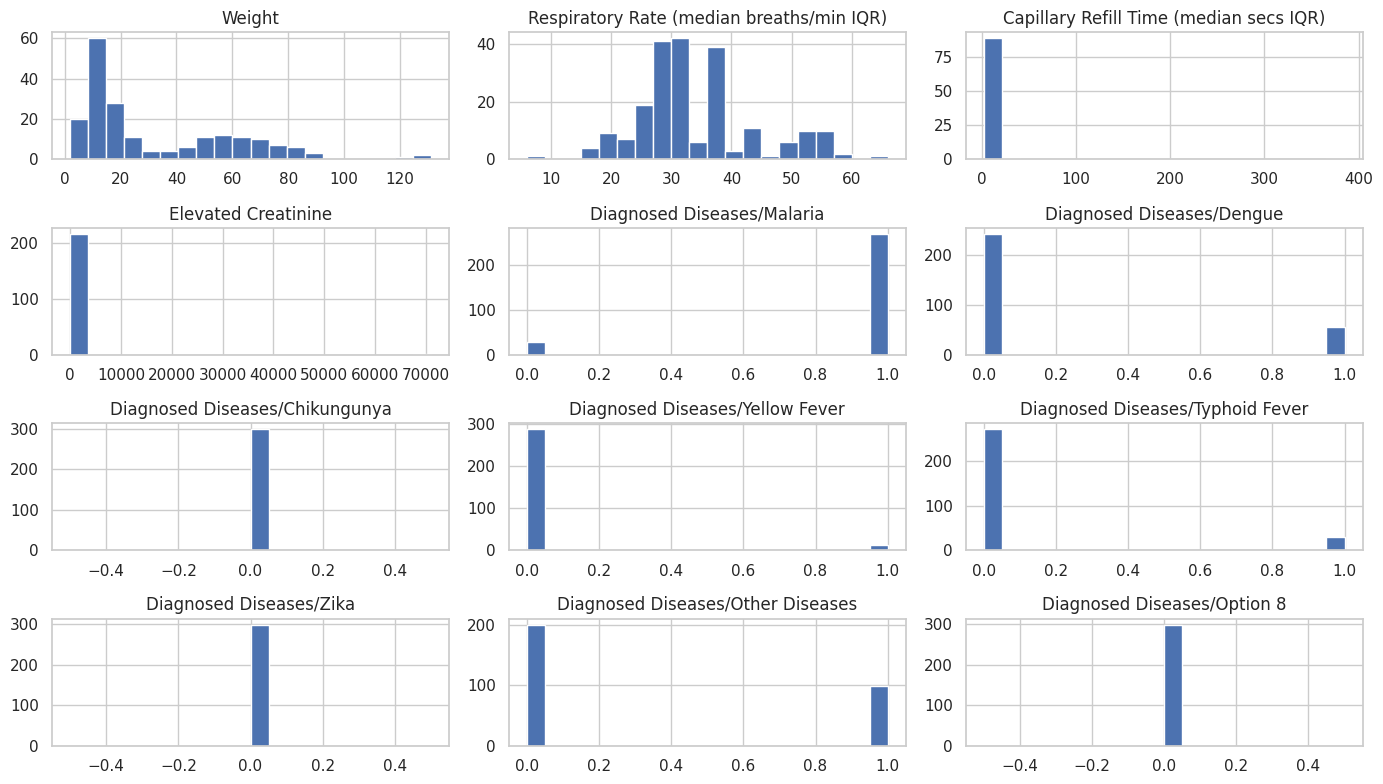

In [14]:
# Normalize column names (strip spaces)
df.columns = [c.strip() for c in df.columns]

# Info & missing values
display(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())

# Show column list
print("\nColumns:", df.columns.tolist())

# Detect likely target column (try common names)
target_candidates = ['disease','Disease','DiseaseLabel','disease_label','target','Target','label','Label']
target_col = None
for c in target_candidates:
    if c in df.columns:
        target_col = c
        break
if target_col is None:
    # fallback: if there's a column with few unique strings look for it
    for c in df.columns:
        if df[c].dtype == object and df[c].nunique() <= 10:
            target_col = c
            break

if target_col is None:
    raise KeyError("Target column not found. Expected a column like 'disease' or similar. Columns: " + ", ".join(df.columns[:50]))

print(f"\nDetected target column: {target_col}")
print(df[target_col].value_counts(dropna=False))

# Numeric summary
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns:", numeric_cols)
display(df[numeric_cols].describe())

# Histograms for numeric features (if any)
if numeric_cols:
    df[numeric_cols].hist(bins=20, figsize=(14,8))
    plt.tight_layout()


## Decide prediction task & target mapping
We'll predict the disease category (multi-class), mapping the text labels to integers using `LabelEncoder`.  
If the detected target column incorrectly picks a feature, update `target_col` variable above before rerunning.


In [15]:
# Map / encode target using LabelEncoder
raw_target = df[target_col].astype(str).fillna("Unknown")
le = LabelEncoder()
y_raw = raw_target
y = le.fit_transform(y_raw)

print("Detected classes and integer mapping:")
class_map = dict(zip(le.classes_, le.transform(le.classes_)))
print(class_map)

print("\nTarget distribution (counts):")
print(pd.Series(y).value_counts().sort_index())

# Save label encoder path for later
label_encoder_path = os.path.join(DRIVE_MODEL_DIR, "label_encoder.pkl")
joblib.dump(le, label_encoder_path)
print("Saved label encoder to:", label_encoder_path)


Detected classes and integer mapping:
{'CMA de DAFRA': np.int64(0), 'CMA de DO': np.int64(1)}

Target distribution (counts):
0    153
1    147
Name: count, dtype: int64
Saved label encoder to: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/vector_borne_classifier/label_encoder.pkl


## Feature selection & preprocessing plan
- Features: all columns except the target column and obvious metadata (Name/ID).  
- Encode categorical features if present (LabelEncoding / one-hot) — prefer to keep inputs numeric for this first version.  
- Fill missing values with median (numeric) or mode (categorical).  
- Scale numeric features using StandardScaler (fit on training set).  
- Train/val/test split: 70% train / 15% validation / 15% test (stratified on target).  
- Models: Logistic Regression (multinomial), Random Forest (multi-class), Keras NN (softmax).


In [22]:
# Auto-select features: exclude target and obvious metadata
exclude_cols = {target_col, 'Name', 'name', 'ID', 'Id', 'id'}

# Handle duplicate column names in the *original* dataframe's columns
original_cols = pd.Series(df.columns)
new_cols_names = []
for dup in original_cols[original_cols.duplicated()].unique():
    temp_list = original_cols[original_cols == dup].index.values.tolist()
    for i, index in enumerate(temp_list):
        if i == 0:
            new_cols_names.append(original_cols[index])
        else:
            new_cols_names.append(f"{original_cols[index]}_{i}")
    original_cols[temp_list] = [f"{original_cols[index]}_{i}" if i != 0 else original_cols[index] for i in range(sum(original_cols == dup))]

df.columns = original_cols # Apply the new column names to the dataframe


# Now create the feature list excluding the target and metadata
features = [c for c in df.columns if c not in exclude_cols]
print("Candidate features:", features)


# Create X (copy to avoid modifying original)
X = df[features].copy()


# Handle missing values: numeric -> median, object -> mode
for c in X.columns:
    if pd.api.types.is_numeric_dtype(X[c]):
        X[c] = X[c].fillna(X[c].median())
    else:
        X[c] = X[c].fillna(X[c].mode().iloc[0])

# Convert any remaining object columns to numeric where possible, otherwise label-encode
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
print("Categorical columns detected:", cat_cols)
for c in cat_cols:
    # try to coerce to numeric first
    coerced = pd.to_numeric(X[c], errors='coerce')
    if coerced.notnull().sum() > 0 and coerced.isnull().sum() < len(coerced):
        X[c] = coerced.fillna(coerced.median())
    else:
        # label encode
        le_col = LabelEncoder()
        X[c] = le_col.fit_transform(X[c].astype(str))


# Final feature list
feature_list = X.columns.tolist()
print("Final feature list (used for modelling):", feature_list)

# Quick sanity check
display(X.head())

Candidate features: ['Gender', 'Age', 'Weight', 'Arm Circumference', 'High Temperature (Hyperpyrexia)', 'Fever since 48 hrs', 'Fever in the last 7 days', 'Type of Fever', 'Loss of Weight', 'Headache', 'Nausea', 'Vomiting', 'Joint Pain', 'Joint Swelling', 'Muscle Pain', 'Chest Pain', 'Back Pain / Rachiodynia', 'Consciousness Trouble', 'Loss of Appetite or Anorexia', 'Skin Rash or Exanthema', 'Morbilliform Rash', 'Bleeding / Hemorrhagic Manifestations', 'Rhinorrhea', 'Drowsiness or Lethargy', 'Dizzy', 'Conjunctivitis Inflammation', 'Abdominal Pain (Stomach Pain)', 'Abdominal Distension (Swelling Stomach) / Ascites', 'Throat Pain', 'Cough', 'Diarrhea', 'Retro-orbital Pain', 'Headache_1', 'Shiver or Cold Sensation', 'Frequent Urination', 'Constipation', 'Oliguria', 'Mictions fréquentes. (Frequent Urination)', 'Prostration', 'Icterus', 'Epistaxis (Bleeding Nose)', 'Generalised or Focal Convulsion', 'Multiple Convulsions', 'Delirium', 'Confusion / Impaired Level of Consciousness', 'Facial Fl

,Gender,Age,Weight,Arm Circumference,High Temperature (Hyperpyrexia),Fever since 48 hrs,Fever in the last 7 days,Type of Fever,Loss of Weight,Headache,...,Diagnosed Diseases/Malaria,Diagnosed Diseases/Dengue,Diagnosed Diseases/Chikungunya,Diagnosed Diseases/Yellow Fever,Diagnosed Diseases/Typhoid Fever,Diagnosed Diseases/Zika,Diagnosed Diseases/Other Diseases,Diagnosed Diseases/Option 8,Other Diseases Presented by Patient,_uuid
0,0,18.0,55.0,13.0,1,1,1,1,0,1,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4,252
1,1,26.0,120.0,13.0,1,1,1,1,0,1,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4,86
2,1,25.0,63.0,13.0,1,1,1,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,17
3,1,3.0,12.0,13.0,1,1,0,1,0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,32
4,1,8.0,24.0,13.0,1,1,0,1,0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,268


## Train / Validation / Test split
We split data into:
- Train: 70%
- Validation: 15%
- Test: 15%
We stratify by target to preserve class balance.


In [23]:
# Stratified split: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

# Split temp into val & test (each 15% overall)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Sizes -> Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Class distribution in train:", np.bincount(y_train), "val:", np.bincount(y_val), "test:", np.bincount(y_test))

# Scale numeric features (fit only on training data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Save scaler and feature list for later inference
scaler_path = os.path.join(DRIVE_MODEL_DIR, "scaler_vector_borne.pkl")
joblib.dump(scaler, scaler_path)
feat_file = os.path.join(DRIVE_MODEL_DIR, "feature_list_vector_borne.json")
with open(feat_file, "w") as f:
    json.dump(feature_list, f)
print("Saved scaler to:", scaler_path)
print("Saved feature list to:", feat_file)


Sizes -> Train: (210, 108) Val: (45, 108) Test: (45, 108)
Class distribution in train: [107 103] val: [23 22] test: [23 22]
Saved scaler to: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/vector_borne_classifier/scaler_vector_borne.pkl
Saved feature list to: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/vector_borne_classifier/feature_list_vector_borne.json


## Baseline model: Logistic Regression
Train a multinomial logistic regression baseline (solver='lbfgs' supports multinomial).
We'll evaluate on the validation set.


In [24]:
# Multinomial logistic regression
lr = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', class_weight='balanced', random_state=42)
lr.fit(X_train_scaled, y_train)

# Validate
y_val_pred_lr = lr.predict(X_val_scaled)
y_val_proba_lr = lr.predict_proba(X_val_scaled)

print("Validation classification report (Logistic Regression):\n")
print(classification_report(y_val, y_val_pred_lr, target_names=le.classes_))


Validation classification report (Logistic Regression):

              precision    recall  f1-score   support

CMA de DAFRA       0.96      0.96      0.96        23
   CMA de DO       0.95      0.95      0.95        22

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


## Ensemble baseline: Random Forest
Train a RandomForestClassifier and inspect validation performance and feature importances.


In [25]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_train_scaled, y_train)

# Validation
y_val_pred_rf = rf.predict(X_val_scaled)
y_val_proba_rf = rf.predict_proba(X_val_scaled)

print("Validation classification report (Random Forest):\n")
print(classification_report(y_val, y_val_pred_rf, target_names=le.classes_))

# Feature importances
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=feature_list).sort_values(ascending=False)
print("\nTop feature importances:\n", feat_imp.head(20))

# Save RF model
rf_path = os.path.join(DRIVE_MODEL_DIR, "rf_vector_borne.pkl")
joblib.dump(rf, rf_path)
print("Saved Random Forest to:", rf_path)


Validation classification report (Random Forest):

              precision    recall  f1-score   support

CMA de DAFRA       1.00      1.00      1.00        23
   CMA de DO       1.00      1.00      1.00        22

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45


Top feature importances:
 White Blood Cell Count / WBC Count (cells/ML)              0.118847
Type of Fever                                              0.106748
Platelet Count                                             0.106734
Lymphocytes                                                0.071527
Positive Tourniquet Test                                   0.065856
Neutrophils                                                0.050328
Axillary Temperature (median IQR) (°C)                     0.037813
Headache_1                                                 0.031495
Hemoconcentration                                  

## Neural network (Keras)
A small dense NN with dropout and EarlyStopping. We will save the best model to Drive.


In [26]:
# Build NN
tf.random.set_seed(42)
nn_version = "v1"
input_dim = X_train_scaled.shape[1]
num_classes = len(le.classes_)

nn = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks: EarlyStopping + ModelCheckpoint
nn_model_file = os.path.join(DRIVE_MODEL_DIR, f"nn_vector_borne_{nn_version}.h5")
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
mc = ModelCheckpoint(nn_model_file, monitor='val_loss', save_best_only=True)

# Train
history = nn.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                 epochs=100, batch_size=16, callbacks=[es, mc], verbose=2)

print("Best NN model saved to:", nn_model_file)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


14/14 - 4s - 250ms/step - accuracy: 0.6476 - loss: 0.6632 - val_accuracy: 0.8222 - val_loss: 13.4913
Epoch 2/100
14/14 - 0s - 30ms/step - accuracy: 0.9000 - loss: 0.3508 - val_accuracy: 0.8889 - val_loss: 14.7788
Epoch 3/100
14/14 - 0s - 10ms/step - accuracy: 0.9619 - loss: 0.1864 - val_accuracy: 0.9333 - val_loss: 17.6241
Epoch 4/100
14/14 - 0s - 8ms/step - accuracy: 0.9619 - loss: 0.1378 - val_accuracy: 0.9333 - val_loss: 20.1962
Epoch 5/100
14/14 - 0s - 12ms/step - accuracy: 0.9810 - loss: 0.0970 - val_accuracy: 0.9333 - val_loss: 16.9496
Epoch 6/100
14/14 - 0s - 8ms/step - accuracy: 0.9857 - loss: 0.0815 - val_accuracy: 0.9333 - val_loss: 19.8859
Epoch 7/100
14/14 - 0s - 8ms/step - accuracy: 0.9810 - loss: 0.0670 - val_accuracy: 0.9333 - val_loss: 21.4189
Epoch 8/100
14/14 - 0s - 10ms/step - accuracy: 0.9952 - loss: 0.0489 - val_accuracy: 0.9333 - val_loss: 17.5861
Epoch 9/100
14/14 - 0s - 8ms/step - accuracy: 0.9952 - loss: 0.0471 - val_accuracy: 0.9333 - val_loss: 19.0154
Best NN

## Training curves for the neural network
We will plot training & validation loss and accuracy to check for overfitting.


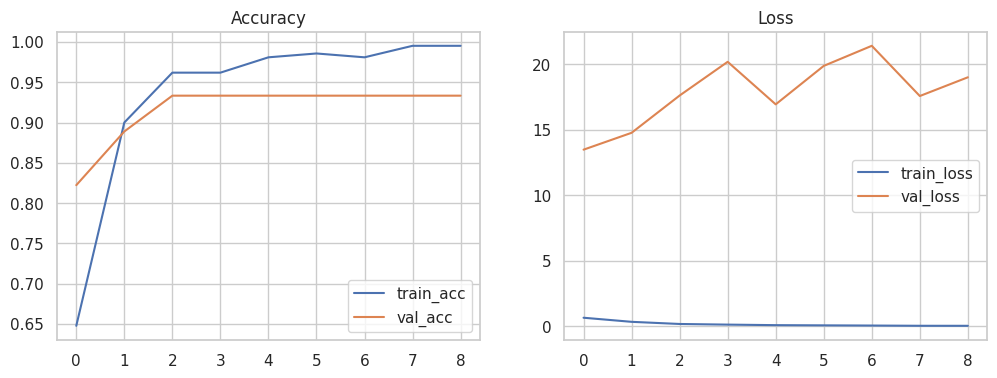

In [27]:
# Plot accuracy and loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history.get('accuracy', []), label='train_acc')
plt.plot(history.history.get('val_accuracy', []), label='val_acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history.get('loss', []), label='train_loss')
plt.plot(history.history.get('val_loss', []), label='val_loss')
plt.title("Loss")
plt.legend()
plt.show()


## Evaluate all selected models on the TEST set
We will evaluate Logistic Regression, Random Forest, and the best Neural Network on the reserved test set.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step

=== Logistic Regression ===
Accuracy: 0.9555555555555556
Precision (macro): 0.9555335968379447
Recall (macro): 0.9555335968379447
F1 (macro): 0.9555335968379447
ROC AUC: N/A y should be a 1d array, got an array of shape (45, 2) instead.

Classification report:
              precision    recall  f1-score   support

CMA de DAFRA       0.96      0.96      0.96        23
   CMA de DO       0.95      0.95      0.95        22

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



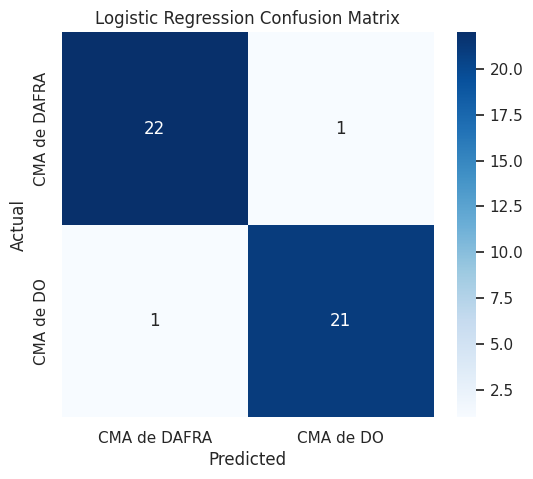


=== Random Forest ===
Accuracy: 1.0
Precision (macro): 1.0
Recall (macro): 1.0
F1 (macro): 1.0
ROC AUC: N/A y should be a 1d array, got an array of shape (45, 2) instead.

Classification report:
              precision    recall  f1-score   support

CMA de DAFRA       1.00      1.00      1.00        23
   CMA de DO       1.00      1.00      1.00        22

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



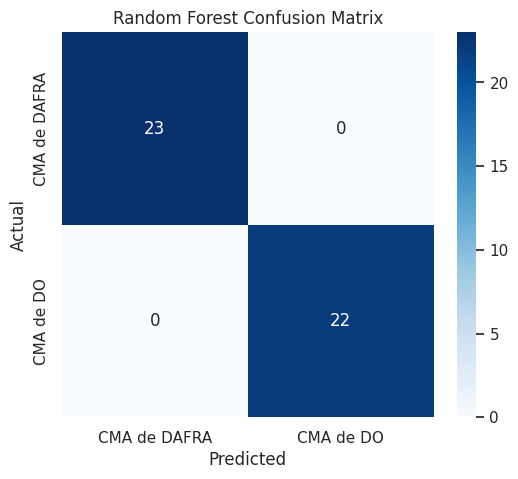


=== Neural Network ===
Accuracy: 0.7777777777777778
Precision (macro): 0.7995689655172413
Recall (macro): 0.7747035573122529
F1 (macro): 0.7722672064777327
ROC AUC: N/A y should be a 1d array, got an array of shape (45, 2) instead.

Classification report:
              precision    recall  f1-score   support

CMA de DAFRA       0.72      0.91      0.81        23
   CMA de DO       0.88      0.64      0.74        22

    accuracy                           0.78        45
   macro avg       0.80      0.77      0.77        45
weighted avg       0.80      0.78      0.77        45



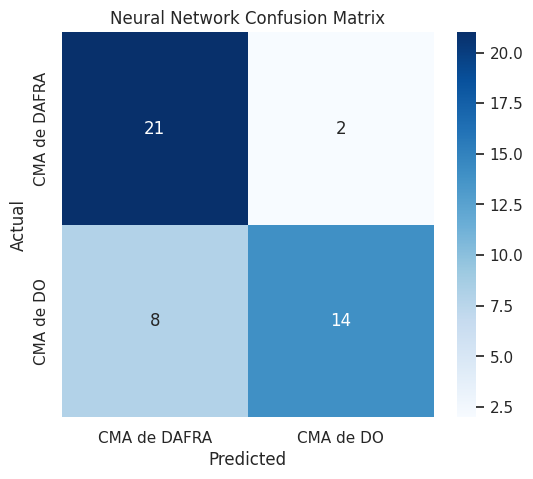

In [28]:
# Logistic Regression
y_test_pred_lr = lr.predict(X_test_scaled)
# For multiclass roc_auc try/except
try:
    y_test_proba_lr = lr.predict_proba(X_test_scaled)
except:
    y_test_proba_lr = None

# Random Forest
y_test_pred_rf = rf.predict(X_test_scaled)
y_test_proba_rf = rf.predict_proba(X_test_scaled)

# Neural Net - load best saved model and predict
nn_loaded = tf.keras.models.load_model(nn_model_file)
y_test_proba_nn = nn_loaded.predict(X_test_scaled)
y_test_pred_nn = np.argmax(y_test_proba_nn, axis=1)

# Utility to print metrics & plot confusion matrix
def print_metrics_multi(y_true, y_pred, y_proba, model_name="Model"):
    print(f"\n=== {model_name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average='macro', zero_division=0))
    print("Recall (macro):", recall_score(y_true, y_pred, average='macro', zero_division=0))
    print("F1 (macro):", f1_score(y_true, y_pred, average='macro', zero_division=0))
    try:
        if y_proba is not None:
            print("ROC AUC (ovr):", roc_auc_score(y_true, y_proba, multi_class='ovr'))
        else:
            print("ROC AUC: N/A")
    except Exception as e:
        print("ROC AUC: N/A", e)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(model_name + " Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

# Print metrics
print_metrics_multi(y_test, y_test_pred_lr, y_test_proba_lr, "Logistic Regression")
print_metrics_multi(y_test, y_test_pred_rf, y_test_proba_rf, "Random Forest")
print_metrics_multi(y_test, y_test_pred_nn, y_test_proba_nn, "Neural Network")


## Save model artifacts and metadata for integration
We will save:
- The final models (lr, rf, nn)
- Scaler (already saved)
- Feature list (saved)
- Label encoder (saved earlier)
- metadata.json describing model versions and input format
All saved inside `DRIVE_MODEL_DIR`.


In [29]:
# Save logistic regression & RF (NN is saved already)
lr_path = os.path.join(DRIVE_MODEL_DIR, "lr_vector_borne.pkl")
joblib.dump(lr, lr_path)
print("Saved Logistic Regression to:", lr_path)

rf_path = os.path.join(DRIVE_MODEL_DIR, "rf_vector_borne.pkl")
joblib.dump(rf, rf_path)
print("Saved Random Forest to:", rf_path)

# Feature list saved earlier; ensure metadata
metadata = {
    "model_name": "vector_borne_classifier",
    "models": {
        "logistic_regression": os.path.basename(lr_path),
        "random_forest": os.path.basename(rf_path),
        "neural_network": os.path.basename(nn_model_file)
    },
    "features": feature_list,
    "target_column": target_col,
    "label_encoder": os.path.basename(label_encoder_path),
    "scaler": os.path.basename(scaler_path),
    "notes": "Multi-class classifier for Malaria, Dengue, Yellow Fever, Typhoid, and Controls. For research/demo use only (not a medical diagnosis)."
}

meta_file = os.path.join(DRIVE_MODEL_DIR, "metadata_vector_borne.json")
with open(meta_file, "w") as f:
    json.dump(metadata, f, indent=2)
print("Saved metadata to:", meta_file)


Saved Logistic Regression to: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/vector_borne_classifier/lr_vector_borne.pkl
Saved Random Forest to: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/vector_borne_classifier/rf_vector_borne.pkl
Saved metadata to: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/vector_borne_classifier/metadata_vector_borne.json


## Prediction helper for chatbot/backend
A reusable function that:
- Accepts a dict of raw inputs (feature_name -> value)
- Builds a DataFrame in the correct feature order
- Applies the scaler and chosen model
- Returns probability distribution over classes, predicted label, and human-friendly text


In [30]:
# Load artifacts for inference
scaler = joblib.load(scaler_path)
rf_model = joblib.load(rf_path)
lr_model = joblib.load(lr_path)
nn_model = nn_loaded
with open(feat_file, "r") as f:
    feature_list = json.load(f)
label_encoder = joblib.load(label_encoder_path)

def prepare_input(raw_input: dict):
    row = {f: raw_input.get(f, 0) for f in feature_list}
    df_row = pd.DataFrame([row], columns=feature_list)
    df_row = df_row.fillna(0)
    arr = scaler.transform(df_row)
    return arr

def predict_vector_borne(raw_input: dict, model_type="rf"):
    arr = prepare_input(raw_input)
    if model_type == "rf":
        probs = rf_model.predict_proba(arr)[0]
    elif model_type == "lr":
        probs = lr_model.predict_proba(arr)[0]
    elif model_type == "nn":
        probs = nn_model.predict(arr).ravel()
    else:
        raise ValueError("model_type must be one of ['rf','lr','nn']")
    pred_idx = int(np.argmax(probs))
    pred_label = label_encoder.inverse_transform([pred_idx])[0]
    probs_dict = {label_encoder.inverse_transform([i])[0]: float(probs[i]) for i in range(len(probs))}
    return {"probabilities": probs_dict, "pred_index": pred_idx, "prediction": pred_label}

# Test prediction with a dummy input (use realistic feature keys/values)
sample_input = {f: float(X_test.iloc[0][f]) if f in X_test.columns else 0 for f in feature_list}
print("Sample input keys:", list(sample_input.keys())[:10])
print("RF prediction:", predict_vector_borne(sample_input, "rf"))
print("LR prediction:", predict_vector_borne(sample_input, "lr"))
print("NN prediction:", predict_vector_borne(sample_input, "nn"))


Sample input keys: ['Gender', 'Age', 'Weight', 'Arm Circumference', 'High Temperature (Hyperpyrexia)', 'Fever since 48 hrs', 'Fever in the last 7 days', 'Type of Fever', 'Loss of Weight', 'Headache']
RF prediction: {'probabilities': {'CMA de DAFRA': 0.98, 'CMA de DO': 0.02}, 'pred_index': 0, 'prediction': 'CMA de DAFRA'}
LR prediction: {'probabilities': {'CMA de DAFRA': 0.9987036789812456, 'CMA de DO': 0.0012963210187544676}, 'pred_index': 0, 'prediction': 'CMA de DAFRA'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
NN prediction: {'probabilities': {'CMA de DAFRA': 0.8257344365119934, 'CMA de DO': 0.17426559329032898}, 'pred_index': 0, 'prediction': 'CMA de DAFRA'}


## FastAPI snippet — serve model as HTTP endpoint
Save this as `app.py` and deploy (Gunicorn/uvicorn) - the chatbot will call `/predict` with JSON payload.


In [31]:
fastapi_snippet = f'''
from fastapi import FastAPI
from pydantic import BaseModel
import joblib, json, pandas as pd, tensorflow as tf

app = FastAPI()

# Update these paths if different in production
SCALER_PATH = "{scaler_path}"
RF_PATH = "{rf_path}"
LR_PATH = "{lr_path}"
NN_PATH = "{nn_model_file}"
LABEL_ENCODER_PATH = "{label_encoder_path}"
FEATURES_PATH = "{feat_file}"

scaler = joblib.load(SCALER_PATH)
rf = joblib.load(RF_PATH)
lr = joblib.load(LR_PATH)
nn = tf.keras.models.load_model(NN_PATH)
label_encoder = joblib.load(LABEL_ENCODER_PATH)
with open(FEATURES_PATH, 'r') as f:
    features = json.load(f)

class Query(BaseModel):
    data: dict
    model_type: str = "rf"

def prepare_input_row(raw_input):
    row = {{f: raw_input.get(f, 0) for f in features}}
    df_row = pd.DataFrame([row], columns=features)
    df_row = df_row.fillna(0)
    arr = scaler.transform(df_row)
    return arr

@app.post("/predict")
def predict(query: Query):
    arr = prepare_input_row(query.data)
    if query.model_type == "rf":
        probs = rf.predict_proba(arr)[0]
    elif query.model_type == "lr":
        probs = lr.predict_proba(arr)[0]
    elif query.model_type == "nn":
        probs = nn.predict(arr).ravel()
    else:
        return {{"error":"unknown model_type"}}
    pred_index = int(probs.argmax())
    pred_label = label_encoder.inverse_transform([pred_index])[0]
    probs_dict = {{label_encoder.inverse_transform([i])[0]: float(probs[i]) for i in range(len(probs))}}
    return {{"probabilities": probs_dict, "pred_index": pred_index, "prediction": pred_label}}
'''
print(fastapi_snippet)



from fastapi import FastAPI
from pydantic import BaseModel
import joblib, json, pandas as pd, tensorflow as tf

app = FastAPI()

# Update these paths if different in production
SCALER_PATH = "/content/drive/MyDrive/SIH_2025/Ayushmitra_Models/vector_borne_classifier/scaler_vector_borne.pkl"
RF_PATH = "/content/drive/MyDrive/SIH_2025/Ayushmitra_Models/vector_borne_classifier/rf_vector_borne.pkl"
LR_PATH = "/content/drive/MyDrive/SIH_2025/Ayushmitra_Models/vector_borne_classifier/lr_vector_borne.pkl"
NN_PATH = "/content/drive/MyDrive/SIH_2025/Ayushmitra_Models/vector_borne_classifier/nn_vector_borne_v1.h5"
LABEL_ENCODER_PATH = "/content/drive/MyDrive/SIH_2025/Ayushmitra_Models/vector_borne_classifier/label_encoder.pkl"
FEATURES_PATH = "/content/drive/MyDrive/SIH_2025/Ayushmitra_Models/vector_borne_classifier/feature_list_vector_borne.json"

scaler = joblib.load(SCALER_PATH)
rf = joblib.load(RF_PATH)
lr = joblib.load(LR_PATH)
nn = tf.keras.models.load_model(NN_PATH)
label_encoder = joblib

## Upload model artifacts to Hugging Face Hub (optional)
Use this code to push your saved artifacts (`.pkl`, `.h5`, `scaler`, README) into a HF model repo.
You need a Hugging Face token (store it in an environment variable or paste it during login).
This function is reusable across notebooks — call `upload_to_hf(local_dir, repo_id, hf_token)`.


In [32]:
# Hugging Face upload helper
from huggingface_hub import HfApi, HfFolder, Repository
import shutil

def upload_to_hf(local_dir, repo_id, hf_token, commit_message="Initial model upload"):
    """
    Upload a local folder to Hugging Face Hub.
    local_dir: local directory containing model artifacts + README.md
    repo_id: "your-username/repo-name"
    hf_token: your huggingface token (string)
    """
    # Save token so Repository can use it
    HfFolder.save_token(hf_token)

    api = HfApi()
    try:
        api.create_repo(repo_id=repo_id, exist_ok=True, token=hf_token)
        print("Repo created/ready:", repo_id)
    except Exception as e:
        print("Repo create/exists (continuing):", e)

    # Use Repository to push (it will clone the remote)
    repo = Repository(local_dir, clone_from=repo_id, use_auth_token=hf_token)
    repo.push_to_hub(commit_message=commit_message)
    print("Uploaded to HF repo:", repo_id)

# Prepare local folder to upload
local_dir = "hf_vector_borne_model"
if os.path.exists(local_dir):
    shutil.rmtree(local_dir)
os.makedirs(local_dir, exist_ok=True)

# Copy artifacts into local_dir
artifacts = [lr_path, rf_path, nn_model_file, scaler_path, feat_file, label_encoder_path, meta_file]
for p in artifacts:
    if os.path.exists(p):
        shutil.copy(p, local_dir)

# Create README
with open(os.path.join(local_dir, "README.md"), "w") as f:
    f.write("# Vector Borne Disease Classifier\n\nModel artifacts for multi-class vector-borne disease classifier.\n")

print("Local HF folder prepared at:", local_dir)
print("When ready, call: upload_to_hf(local_dir, 'your-username/vector-borne-classifier', hf_token='hf_xxx')")


Local HF folder prepared at: hf_vector_borne_model
When ready, call: upload_to_hf(local_dir, 'your-username/vector-borne-classifier', hf_token='hf_xxx')


## Integration notes for the chatbot
- **Endpoint**: `POST /predict`
- **Payload**: `{ "data": {"feature1":value, "feature2":value, ...}, "model_type": "rf" }`
- **Response**: `{ "probabilities": {"Malaria":0.7,"Dengue":0.1,...}, "pred_index": 0, "prediction": "Malaria" }`

Best practices:
- Always show model confidence and a short disclaimer (not a diagnosis).
- If model confidence is low (top probability < 0.6), the bot should ask follow-up questions or suggest clinician review.
- Log queries + model outputs (anonymized) for retraining and monitoring.


### Final notes & reproducibility
- Keep `data.csv`, `description.xlsx`, `scaler_vector_borne.pkl`, `feature_list_vector_borne.json`, `label_encoder.pkl`, `metadata_vector_borne.json`, and model files together in `DRIVE_MODEL_DIR`.  
- Use the `upload_to_hf` helper to push artifacts to Hugging Face.  
- For production, prefer HF Inference Endpoints or a managed model registry for scalability & security.  
- This notebook is a reproducible starting point for the vector-borne disease classification component of Ayushmitra.
